# Lets train on real data
We might also have false positives, but for now lets just use true positives/negatives.

Seems we need rotations and noise to get it to work nicely.
It seems to be a good idea to train the network on noise-free images first
and then train on noisy images.

In [5]:
import os

# Load imates into memory

path_tp = 'Images\True_Positive'
path_tn = 'Images\True_Negative'

# loop on all files of the folder and build a list of files paths
images_tp_fn = [os.path.join(path_tp, f) for f in os.listdir(path_tp) if os.path.isfile(os.path.join(path_tp, f))]
images_tn_fn = [os.path.join(path_tn, f) for f in os.listdir(path_tn) if os.path.isfile(os.path.join(path_tn, f))]


Number of tp 145
Number of tn 82


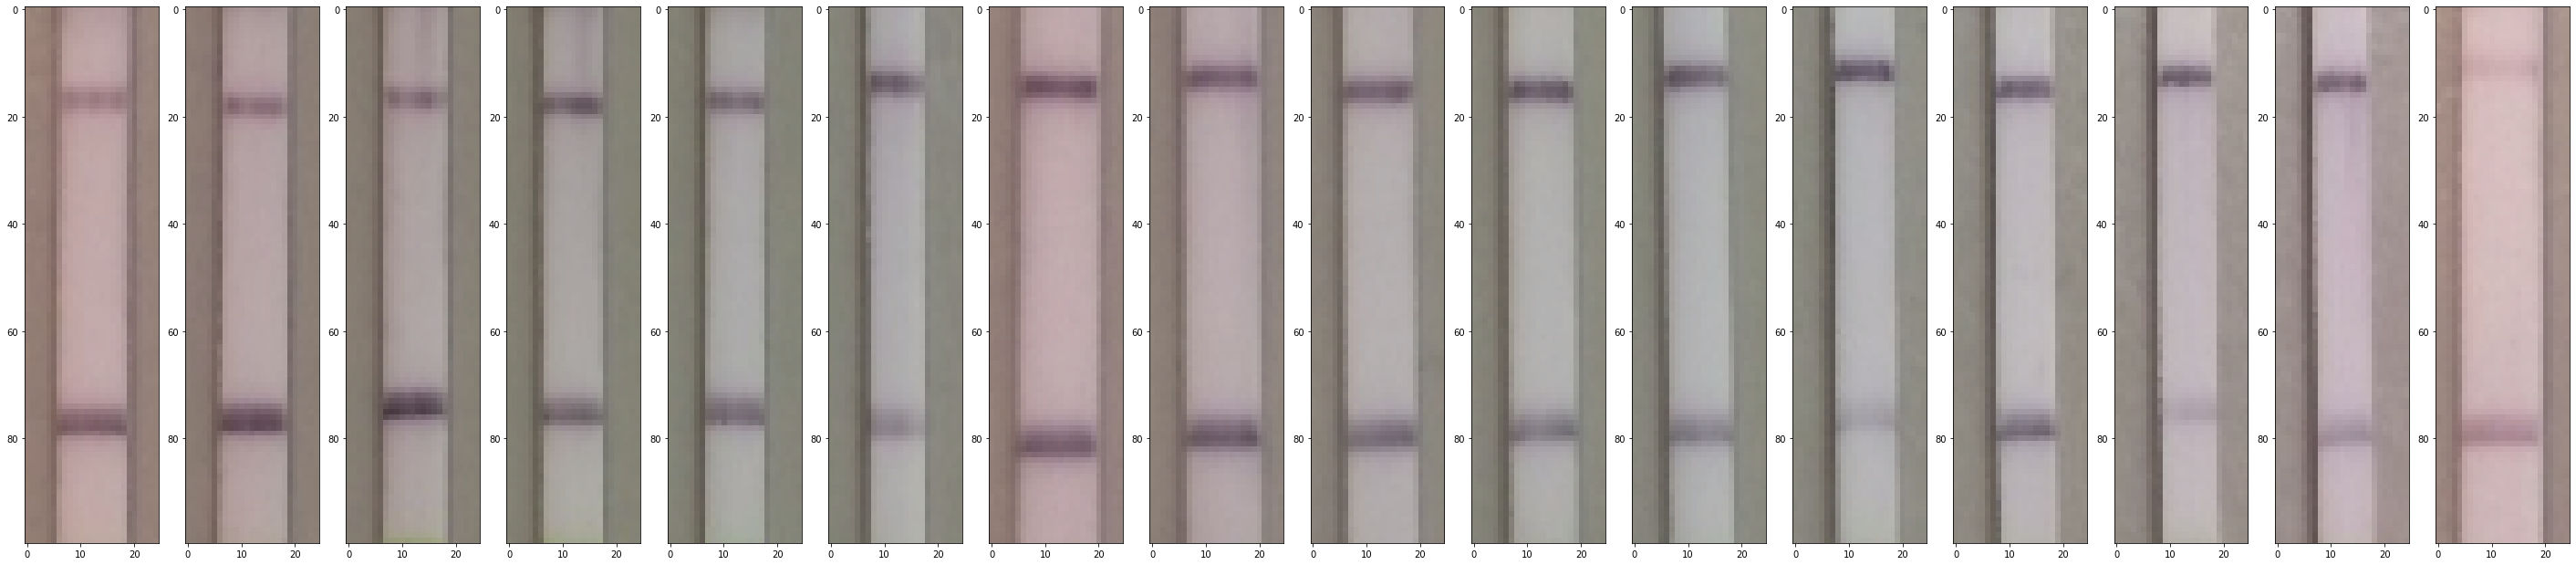

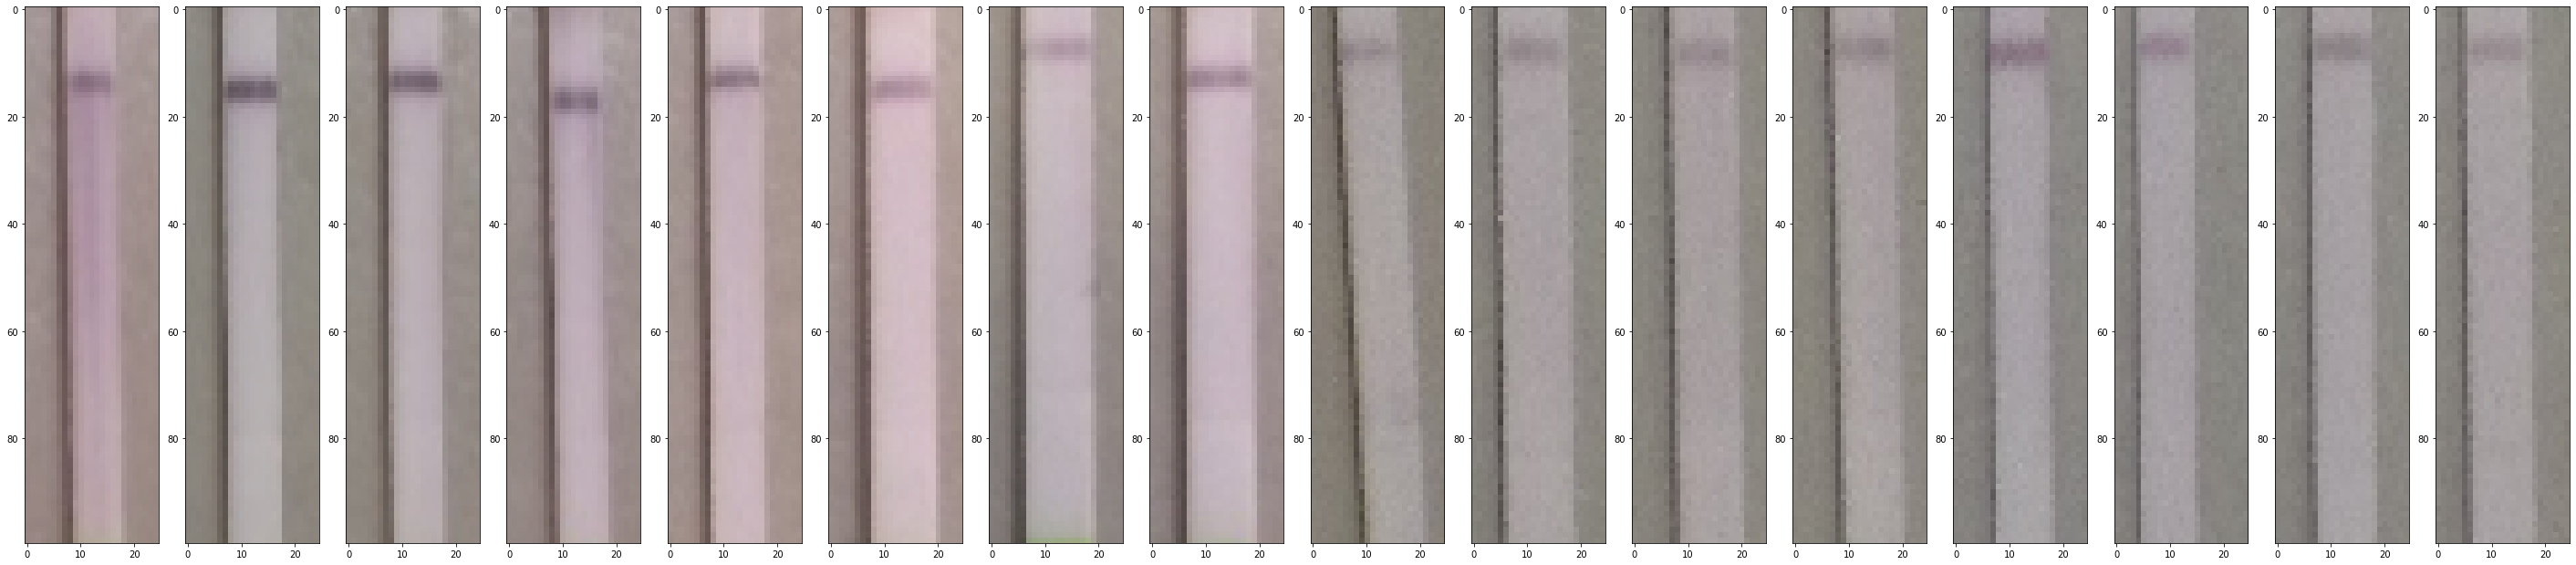

In [8]:
import skimage as sk
import numpy as np
from scipy import ndarray

target_image_shape = (100, 25, 4)
#target_image_shape = (25, 25, 4)

def load_images(paths):
    
    images = ndarray(shape=(len(paths), *target_image_shape))
    #images = ndarray(shape=(len(paths), 50, 25, 4))
    
    for ii, fname in enumerate(paths):
        image = sk.io.imread(fname)
        image = sk.transform.resize(image, target_image_shape, anti_aliasing=False)
        
        # Exclude the top half of the images
        #image = image[50:, :, :]
        
        images[ii, :] = image
        
    return images

images_tp = load_images(images_tp_fn)
images_tn = load_images(images_tn_fn)

print('Number of tp', len(images_tp))
print('Number of tn', len(images_tn))

fig_tp = plt.figure(figsize=(50, 50))  # width, height in inches
fig_tn = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(4*4):
    sub = fig_tp.add_subplot(1,16, i + 1)
    sub.imshow(images_tp[i,:], interpolation='nearest')
    
    sub = fig_tn.add_subplot(1,16, i + 1)
    sub.imshow(images_tn[i,:], interpolation='nearest')
        

# Reserve some data for final validation

In [7]:
num_final_validation = 5

# Shuffle first
np.random.shuffle(images_tp)
np.random.shuffle(images_tn)

images_tp_valid = images_tp[:num_final_validation]
images_tn_valid = images_tn[:num_final_validation]

images_tp = images_tp[num_final_validation:]
images_tn = images_tn[num_final_validation:]

print('Number of tp', len(images_tp))
print('Number of tn', len(images_tn))

Number of tp 140
Number of tn 77


## Augment the images

In [80]:
import random

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-15, 15)
    #random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array, var=0.001)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def no_transform(image_array: ndarray):
    return image_array


# the number of file to generate
num_files_desired = 1000

# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'none' : no_transform,
    'noise': random_noise #,
    #'horizontal_flip': horizontal_flip
}

def apply_transformations(images_to_transform):
    
    all_images = ndarray(shape=(num_files_desired,
                                images_to_transform.shape[-3],
                                images_to_transform.shape[-2],
                                images_to_transform.shape[-1]))
    
    for ii in range(num_files_desired):
        
        # Choose an image
        img_idx = np.random.randint(0, len(images_to_transform))
        our_img = images_to_transform[img_idx, :]
        
        # Apply a transformation
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](our_img)
        
        all_images[ii, :] = transformed_image
        
    return all_images
        
images_tp_aug = apply_transformations(images_tp)
images_tn_aug = apply_transformations(images_tn)

print('Augmented tp', len(images_tp_aug))
print('Augmented tn', len(images_tn_aug))

Augmented tp 1000
Augmented tn 1000


In [2]:
from matplotlib import pyplot as plt

fig_tp = plt.figure(figsize=(50, 50))  # width, height in inches
fig_tn = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(16):
    sub = fig_tp.add_subplot(1,16, i + 1)
    sub.imshow(images_tp_aug[i,:], interpolation='nearest')
    
    sub = fig_tn.add_subplot(1,16, i + 1)
    sub.imshow(images_tn_aug[i,:], interpolation='nearest')

print(images_tn_aug[1, :].shape)
#labels

NameError: name 'images_tp_aug' is not defined

In [88]:
# Shuffle the data and produce training and validation data

import numpy as np

# Split the data into training and validation

use_aug = False
if not use_aug:
    labels = np.concatenate([np.zeros((images_tp.shape[0], 1)), np.ones((images_tn.shape[0], 1))])
    images_all = np.concatenate([images_tp, images_tn])
else:
    labels = np.concatenate([np.zeros((images_tp_aug.shape[0], 1)), np.ones((images_tn_aug.shape[0], 1))])
    images_all = np.concatenate([images_tp_aug, images_tn_aug])

# Normalize pixel values to be between 0 and 1
images_all = images_all / 255.0

def unison_shuffled_copies(l, s):
    ax = 0
    assert l.shape[ax] == s.shape[ax]
    p = np.random.permutation(l.shape[ax])
    return l[p, :], s[p, :]

labels, images_all = unison_shuffled_copies(labels, images_all)

num_test = round(0.1*len(labels))
num_train = len(labels) - num_test

train_labels = labels[:num_train, :]
train_images = images_all[:num_train, :]

test_labels = labels[num_train:, :]
test_images = images_all[num_train:, :]


print('Number of training', len(train_images))
print('Number of testing', len(test_images))

Number of training 195
Number of testing 22


In [92]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_images.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 48, 23, 32)        1184      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 11, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 22, 9, 64)         18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 11, 4, 64)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 2, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [97]:
#model.load_weights('output_211548.h5')

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

accuracy = model.fit(train_images, train_labels, epochs=200,
              validation_data=(test_images, test_labels))

Train on 195 samples, validate on 22 samples
Epoch 1/200
195/195 [==============================] - 1s 5ms/sample - loss: 0.2837 - acc: 0.8923 - val_loss: 0.1374 - val_acc: 0.9545
Epoch 2/200
195/195 [==============================] - 0s 445us/sample - loss: 0.2880 - acc: 0.8513 - val_loss: 0.3427 - val_acc: 0.8182
Epoch 3/200
195/195 [==============================] - 0s 455us/sample - loss: 0.5943 - acc: 0.8256 - val_loss: 0.3700 - val_acc: 0.7727
Epoch 4/200
195/195 [==============================] - 0s 448us/sample - loss: 0.3000 - acc: 0.8667 - val_loss: 0.0982 - val_acc: 1.0000
Epoch 5/200
195/195 [==============================] - 0s 456us/sample - loss: 0.2139 - acc: 0.9231 - val_loss: 0.1869 - val_acc: 0.9091
Epoch 6/200
195/195 [==============================] - 0s 481us/sample - loss: 0.2178 - acc: 0.8974 - val_loss: 0.0971 - val_acc: 1.0000
Epoch 7/200
195/195 [==============================] - 0s 484us/sample - loss: 0.2294 - acc: 0.8872 - val_loss: 0.1088 - val_acc: 1.000

195/195 [==============================] - 0s 536us/sample - loss: 0.1044 - acc: 0.9333 - val_loss: 0.0861 - val_acc: 0.9545
Epoch 61/200
195/195 [==============================] - 0s 517us/sample - loss: 0.1035 - acc: 0.9436 - val_loss: 0.0792 - val_acc: 0.9545
Epoch 62/200
195/195 [==============================] - 0s 536us/sample - loss: 0.1018 - acc: 0.9538 - val_loss: 0.0807 - val_acc: 0.9545
Epoch 63/200
195/195 [==============================] - 0s 518us/sample - loss: 0.1013 - acc: 0.9436 - val_loss: 0.0967 - val_acc: 0.9545
Epoch 64/200
195/195 [==============================] - 0s 510us/sample - loss: 0.1128 - acc: 0.9436 - val_loss: 0.0890 - val_acc: 1.0000
Epoch 65/200
195/195 [==============================] - 0s 549us/sample - loss: 0.1185 - acc: 0.9487 - val_loss: 0.0860 - val_acc: 0.9545
Epoch 66/200
195/195 [==============================] - 0s 506us/sample - loss: 0.1012 - acc: 0.9590 - val_loss: 0.1081 - val_acc: 0.9091
Epoch 67/200
195/195 [=========================

195/195 [==============================] - 0s 519us/sample - loss: 0.1805 - acc: 0.9128 - val_loss: 0.6505 - val_acc: 0.7273
Epoch 120/200
195/195 [==============================] - 0s 559us/sample - loss: 0.4152 - acc: 0.8667 - val_loss: 0.2218 - val_acc: 0.8636
Epoch 121/200
195/195 [==============================] - 0s 567us/sample - loss: 0.2539 - acc: 0.9077 - val_loss: 0.2142 - val_acc: 0.9545
Epoch 122/200
195/195 [==============================] - 0s 560us/sample - loss: 0.1643 - acc: 0.9385 - val_loss: 0.1990 - val_acc: 0.8636
Epoch 123/200
195/195 [==============================] - 0s 535us/sample - loss: 0.1731 - acc: 0.9128 - val_loss: 0.1763 - val_acc: 0.9091
Epoch 124/200
195/195 [==============================] - 0s 613us/sample - loss: 0.1890 - acc: 0.9436 - val_loss: 0.1490 - val_acc: 0.9545
Epoch 125/200
195/195 [==============================] - 0s 634us/sample - loss: 0.1480 - acc: 0.9231 - val_loss: 0.1708 - val_acc: 0.9545
Epoch 126/200
195/195 [==================

195/195 [==============================] - 0s 467us/sample - loss: 0.0979 - acc: 0.9590 - val_loss: 0.0856 - val_acc: 1.0000
Epoch 179/200
195/195 [==============================] - 0s 488us/sample - loss: 0.1070 - acc: 0.9487 - val_loss: 0.0998 - val_acc: 0.9091
Epoch 180/200
195/195 [==============================] - 0s 463us/sample - loss: 0.0968 - acc: 0.9538 - val_loss: 0.0746 - val_acc: 1.0000
Epoch 181/200
195/195 [==============================] - 0s 542us/sample - loss: 0.0900 - acc: 0.9692 - val_loss: 0.0891 - val_acc: 0.9545
Epoch 182/200
195/195 [==============================] - 0s 459us/sample - loss: 0.0837 - acc: 0.9641 - val_loss: 0.0700 - val_acc: 1.0000
Epoch 183/200
195/195 [==============================] - 0s 456us/sample - loss: 0.0857 - acc: 0.9641 - val_loss: 0.0968 - val_acc: 0.9545
Epoch 184/200
195/195 [==============================] - 0s 471us/sample - loss: 0.0833 - acc: 0.9744 - val_loss: 0.0717 - val_acc: 1.0000
Epoch 185/200
195/195 [==================

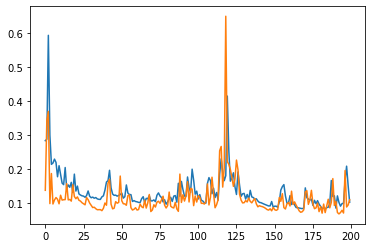

In [98]:
from matplotlib import pyplot as plt

plt.plot(accuracy.history['loss'])
plt.plot(accuracy.history['val_loss'])

In [ ]:
model.load_weights('output_211548.h5')

def check_image(test_image, scale=True):
    
    plt.imshow(test_image*255, extent=[0, 1, 0, 4])
    plt.show()
    print(model.predict(np.array([test_image])))
    
check_image(test_images[5, :])
check_image(test_images[7, :])

fig_tp = plt.figure(figsize=(10, 10))  # width, height in inches
fig_tn = plt.figure(figsize=(10, 10))  # width, height in inches

for i in range(num_final_validation):
    sub = fig_tp.add_subplot(1,num_final_validation, i + 1)
    sub.imshow(images_tp_valid[i,:], interpolation='nearest', extent=[0, 1, 0, 4])
    clas = model.predict(np.array([images_tp_valid[i,:]])/255)
    print(clas)
    if clas[0,0] > clas[0,1]:
        print('Positive')
    else:
        print('Negative')
    
    sub = fig_tn.add_subplot(1,num_final_validation, i + 1)
    sub.imshow(images_tn_valid[i,:], interpolation='nearest', extent=[0, 1, 0, 4])
    clas = model.predict(np.array([images_tn_valid[i,:]])/255)
    print(clas)
    if clas[0,0] > clas[0,1]:
        print('Positive')
    else:
        print('Negative')


In [52]:
# Save the mode to file
model.save('output_211548.h5', overwrite=False)